## Passion Fruits, Object detection and localization model

In [ ]:
#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl#

In [ ]:
import cv2
import ast

import numpy as np 
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg

import random

import torch

import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#import torch_xla
#import torch_xla.core.xla_model as xm

In [ ]:
!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

     |████████████████████████████████| 117 kB 13.0 MB/s 
     |████████████████████████████████| 948 kB 48.5 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=b0b295292252c754e960180698842379f6825baa0d8e6dd84d414702c635e358
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
\#Start by connecting gdrive into the google colab

from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


### Read the csv files

### Train

In [ ]:
train_df = pd.read_csv('/content/gdrive/MyDrive/dataset/train.csv')
train_df.head()

,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0


In [ ]:
train_df.shape

(3906, 6)

In [ ]:
No_duplicates = train_df.drop_duplicates(subset="Image_ID")
print(No_duplicates.shape)

(3001, 6)


We have 3906 bounding boxes, from a collection of 3001 images. Some images have 1 bounding box, while others have more than 1 bounding box.

### Test

In [ ]:
test_df = pd.read_csv("/content/gdrive/MyDrive/dataset/Test.csv")
test_df.head()

,Image_ID
0,ID_IUJJG62B
1,ID_ZPNDRD4T
2,ID_AHFYB64P
3,ID_L8JZLNTF
4,ID_IFMUXGPL


In [ ]:
test_df.shape

(931, 1)

### data preprocessing
- Calculate the xmax and ymax from the train data

In [ ]:
train_df['xmax'] = train_df['xmin']+train_df['width']
train_df['ymax'] = train_df['ymin']+train_df['height']

In [ ]:
train_df.head()

,Image_ID,class,xmin,ymin,width,height,xmax,ymax
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0,315.0,398.5
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5,342.5,372.0
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5,404.5,512.0
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0,379.5,410.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0,313.0,414.5


- Encode the classes from str to int

In [ ]:
classes_la = {"fruit_brownspot": 1, "fruit_healthy": 2, "fruit_woodiness":3}

train_df["class"] = train_df["class"].apply(lambda x: classes_la[x])

In [ ]:
train_df.head()

,Image_ID,class,xmin,ymin,width,height,xmax,ymax
0,ID_007FAIEI,3,87.0,87.5,228.0,311.0,315.0,398.5
1,ID_00G8K1V3,1,97.5,17.5,245.0,354.5,342.5,372.0
2,ID_00WROUT9,1,156.5,209.5,248.0,302.5,404.5,512.0
3,ID_00ZJEEK3,2,125.0,193.0,254.5,217.0,379.5,410.0
4,ID_018UIENR,1,79.5,232.5,233.5,182.0,313.0,414.5


- Most pretrained models reserve label 0 for the background class, therefore we encoded our labels from 1

In [ ]:
df = train_df.copy() # create a copy of the train df

### Visualization

- Let's create sample plots for our Image and the corresponding bounding box

In [ ]:
path = '/content/gdrive/MyDrive/dataset/Train_Images/'

In [ ]:
# group by all bounding boxes (bbox)
df_grp = df.groupby(['Image_ID'])

In [ ]:
def plot_image(image_name):
    image_group = df_grp.get_group(image_name)
    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    img = immg.imread(path+name+'.jpg')
    fig,ax = plt.subplots(figsize=(18,10))
    ax.imshow(img,cmap='binary')
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        print(bbox)
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], image_group["class"].values, verticalalignment='top', color='white', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

   xmin  ymin   xmax   ymax
0  87.0  87.5  315.0  398.5


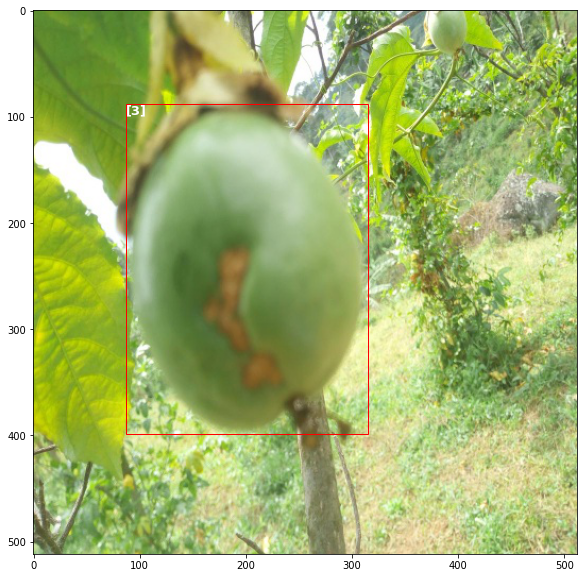

In [ ]:
name = df.Image_ID.unique()[0]
plot_image(name)

      xmin   ymin   xmax   ymax
904  178.0  143.0  350.5  291.0
905  319.0  269.0  391.5  335.5
      xmin   ymin   xmax   ymax
904  178.0  143.0  350.5  291.0
905  319.0  269.0  391.5  335.5


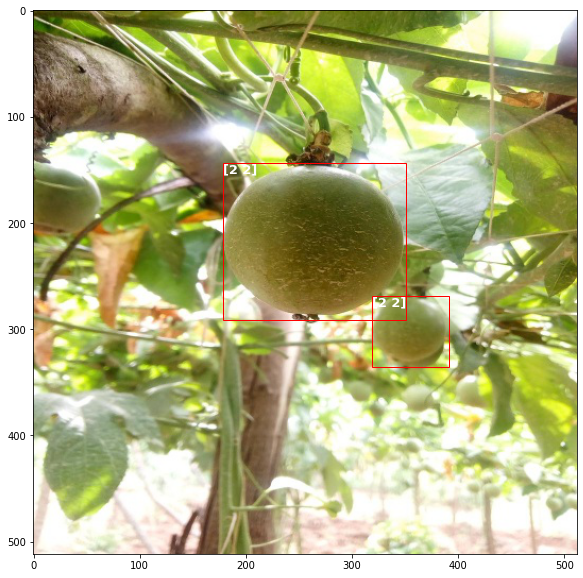

In [ ]:
name = df.Image_ID.unique()[700]
plot_image(name)

     xmin   ymin   xmax   ymax
82  414.0  224.5  512.0  361.5
83  120.0  200.0  420.0  425.0
     xmin   ymin   xmax   ymax
82  414.0  224.5  512.0  361.5
83  120.0  200.0  420.0  425.0


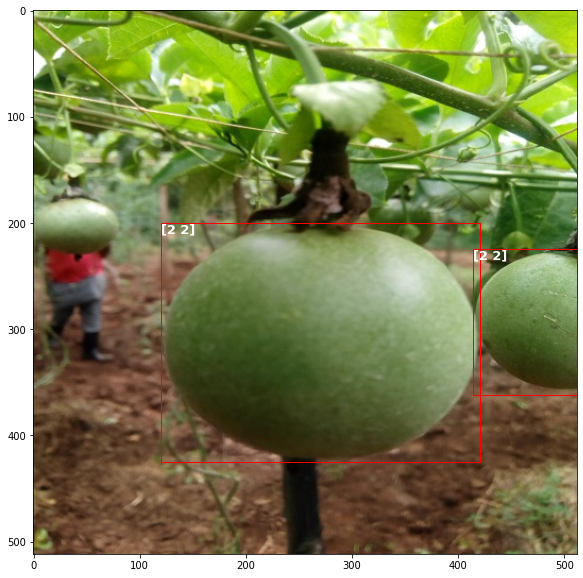

In [ ]:
name = df.Image_ID.unique()[67]
plot_image(name)

#### Create a custom dataset

- We'll create a custom dataset to load our images into PyTorch object detector.

- Sample https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [ ]:
class PassionFruit(object):
    def __init__(self, df, IMG_DIR, transforms):
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df['Image_ID'].unique().tolist()
        self.transforms = transforms
    def __len__(self):
        return len(self.image_ids)
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_values = self.df[self.df['Image_ID'] == image_id]
        image = cv2.imread(self.img_dir+image_id+".jpg",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        boxes = image_values[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        labels = image_values["class"].values
        labels = torch.tensor(labels)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros(len(classes_la), dtype=torch.int64)
        if self.transforms:
                sample = {
                                'image': image,
                                'bboxes': target['boxes'],
                                'labels': labels
                }
        sample = self.transforms(**sample)
        image = sample['image']
        target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)



        return torch.tensor(image), target, image_id


- Define the image transformations. We'll use albumentations package: https://albumentations.ai/

In [ ]:
#!pip install albumentations==0.4.6


In [ ]:

def get_train_transform():
    return A.Compose([
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
        A.RandomBrightness(),
        A.RandomRotate90(),
        A.Rotate(limit=(-90, 90)),
        A.Transpose(),
        A.Downscale (),
        A.RandomContrast(),
        A.RandomBrightnessContrast(),
        A.RandomGamma(),
        A.Blur(),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

- load passion fruit dataset and perform the transormations

In [ ]:
passion_dataset = PassionFruit(df, path, get_train_transform())

- Check if the custom dataset object created ealier works

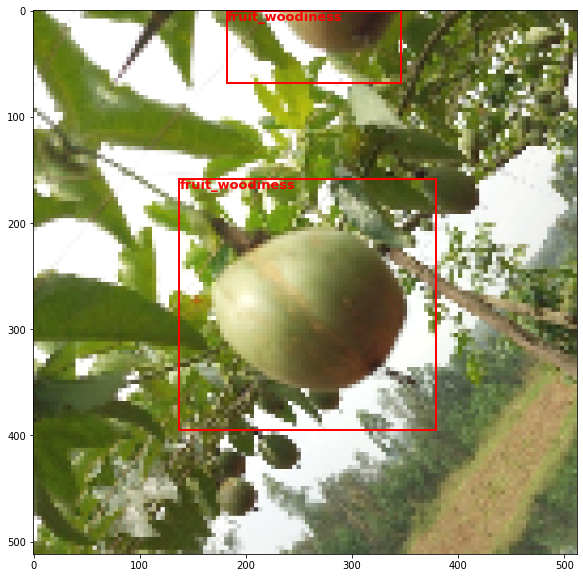

In [ ]:
img, tar, _ = passion_dataset[random.randint(0,1000)]
bbox = tar['boxes']
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for l in tar["labels"].tolist():
    classes_la = {1:"fruit_brownspot",  2:"fruit_healthy", 3:"fruit_woodiness"}
    l = classes_la[l]
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l, verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

#### Split data into training and test

In [ ]:
image_ids = df['Image_ID'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]
valid_df = df[df['Image_ID'].isin(valid_ids)]
train_df = df[df['Image_ID'].isin(train_ids)]
train_df.shape,valid_df.shape

((3054, 8), (852, 8))

### Data Loader

- PyTorch uses dataloader module to make the dataset iterable. We'll pass both the train and val set to the PyTorch DataLoader

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = PassionFruit(train_df, path, get_train_transform())
valid_dataset = PassionFruit(valid_df, path, get_valid_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

- Most pretrained models are trained with a background class, we'll include it in our model, so in that case our number of classes will be 4

In [ ]:
num_classes = 4  # + background

# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

- Train either on GPU if available else CPU 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
num_epochs = 4

#### Training and evaluation

In [ ]:
import sys
best_epoch = 0
min_loss = sys.maxsize

for epoch in range(num_epochs):
    tk = tqdm(train_data_loader)
    model.train();
    for images, targets, image_ids in tk:
        images = list(image.to(device) for image in images)
        ""
        targets = [{k: v.long().to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        tk.set_postfix(train_loss=loss_value)
    tk.close()
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    
    print(f"Epoch #{epoch} loss: {loss_value}") 
        
    #validation 
    model.eval();
    with torch.no_grad():
        tk = tqdm(valid_data_loader)
        for images, targets, image_ids in tk:
        
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            val_output = model(images)
            val_output = [{k: v.to('cpu') for k, v in t.items()} for t in val_output]
            IOU = []
            for j in range(len(val_output)):
                a,b = val_output[j]['boxes'].cpu().detach(), targets[j]['boxes'].cpu().detach()
                chk = torchvision.ops.box_iou(a,b)
                res = np.nanmean(chk.sum(axis=1)/(chk>0).sum(axis=1))
                IOU.append(res)
            tk.set_postfix(IoU=np.mean(IOU))
        tk.close()

  0%|          | 0/292 [00:00<?, ?it/s]

Epoch #0 loss: 0.16171413660049438


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

##### Sample evaluation on validation dataset image

In [ ]:
img,target,_ = valid_dataset[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['boxes']))
print('real #boxes: ', len(target['boxes']))

predicted #boxes:  17
real #boxes:  3


In [ ]:
prediction

{'boxes': tensor([[152.8188, 189.4008, 331.5108, 340.9110],
         [  0.0000, 180.2195,  84.3073, 315.0255],
         [157.0797, 130.3387, 226.8393, 207.1398],
         [213.6793,  89.3721, 341.5335, 207.7974],
         [196.1623,  86.7615, 338.1949, 217.6757],
         [137.7123, 193.9581, 185.1337, 251.2385],
         [184.7439, 134.3071, 231.9428, 195.0482],
         [145.8060, 102.8092, 272.4475, 222.2525],
         [ 29.7699,   0.7852, 168.2681,  46.9373],
         [154.3870,  50.9816, 358.2330, 271.6713],
         [174.0979, 113.5072, 246.3418, 199.6358],
         [164.3843,  76.5410, 374.6040, 227.7456],
         [  0.0000, 132.8041, 107.8064, 349.9019],
         [135.4605, 173.7959, 211.5529, 250.3211],
         [107.9180, 105.4561, 397.7650, 379.3003],
         [  0.0000, 178.4933,  89.7267, 312.5115],
         [203.1693,  81.5499, 347.7001, 211.9773]], device='cuda:0'),
 'labels': tensor([2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 1], device='cuda:0'),
 'scores': tenso

## ground truth box for the sample test

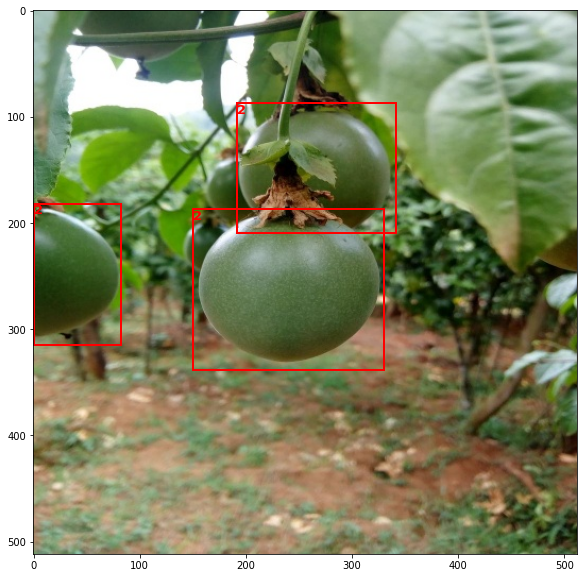

In [ ]:
bbox = target['boxes'].numpy()
fig,ax = plt.subplots(1,figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for l in target["labels"]:
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l.tolist(), verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

## Predicted box for the sample Image

In [ ]:
def plot_valid(img,prediction,nms=True,detect_thresh=0.5):
    fig,ax = plt.subplots(figsize=(18,10))
    val_img = img.permute(1,2,0).cpu().numpy()
    ax.imshow(val_img)
    val_scores = prediction['scores'].cpu().detach().numpy()
    bbox = prediction['boxes'].cpu().detach().numpy()
    for l in target["labels"]:
        for i in range(len(bbox)):
            if val_scores[i]>=detect_thresh:
                box = bbox[i]
                x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
                rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2 ,edgecolor='r',facecolor='none',)
                ax.text(*box[:2], "class " + str(l.tolist()) + " score {0:.3f}".format(val_scores[i]), verticalalignment='top', color='white', fontsize=12, weight='bold')
                ax.add_patch(rect)
        plt.show()

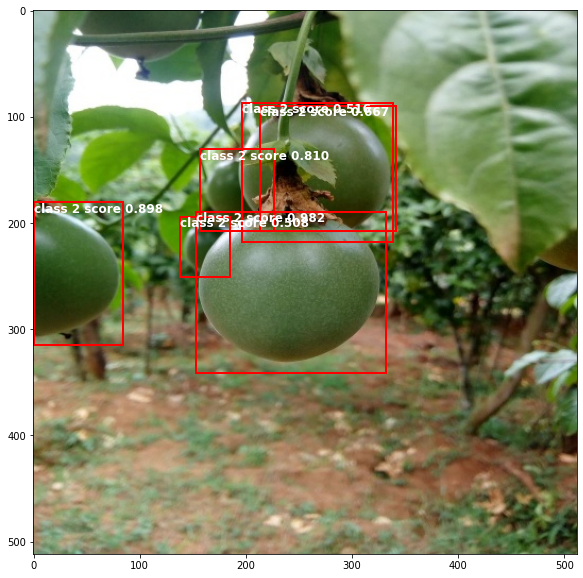

In [ ]:
plot_valid(img,prediction)

#### Load the submission images IDs

- We can load them from the test.csv

In [ ]:
submission = pd.read_csv('/content/gdrive/MyDrive/dataset/Test.csv')

## Create a custom dataset for the test set

In [ ]:
class TestDataset(object):
    def __init__(self, df, IMG_DIR, transforms):        
        self.df = df
        self.img_dir = IMG_DIR
        self.transforms = transforms
        self.image_ids = self.df['Image_ID'].tolist()
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):        
        image_id = self.image_ids[idx]
        image = cv2.imread(self.img_dir+image_id+".jpg",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

### Apply transformation

In [ ]:
def get_test_transform(IMG_SIZE=(512,512)):
    return A.Compose([
         A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        A.Resize(*IMG_SIZE),
        ToTensorV2(p=1.0)
    ])

In [ ]:
test_img_dir = '/content/gdrive/MyDrive/dataset/Test_Images/'

- The training images were of size 515 x 512, resize the test images to the same dimensions.

In [ ]:
IMG_SIZE = (512,512)

In [ ]:
test_dataset = TestDataset(submission, test_img_dir ,get_test_transform())

### Predicting on testset,  create submission

In [ ]:
results = []
for j in range(submission.shape[0]):
    
    img,_ = test_dataset[j]
    img = img.unsqueeze_(0)
    # put the model in evaluation mode
    model.eval()

    with torch.no_grad():
        prediction = model([img.to(device)][0])
        aa = zip(prediction[0]["boxes"].tolist(), prediction[0]["labels"].tolist(), prediction[0]["scores"].tolist())
       
        for item in list(aa):
            row_dict = {}
            row_dict["Image_ID"] = _
            row_dict["boxes"] = item[0]
            row_dict["labels"] = item[1]
            row_dict["confidence"] = item[2]
            results.append(row_dict)
sub_df = pd.DataFrame(results)

In [ ]:
sub_df["ymin"] = sub_df["boxes"].apply(lambda x: x[1])
sub_df["xmin"] = sub_df["boxes"].apply(lambda x: x[0])
sub_df["ymax"] = sub_df["boxes"].apply(lambda x: x[3])
sub_df["xmax"]=  sub_df["boxes"].apply(lambda x: x[2])

In [ ]:
classes_la = {0:"Background", 1:"fruit_brownspot", 2:"fruit_healthy", 3:"fruit_woodiness"}
sub_df["labels"] = sub_df["labels"].apply(lambda x: classes_la[x])

In [ ]:
sub_df.drop(["boxes"], axis=1, inplace=True)

In [ ]:
sub_df.rename(columns={"labels":"class"}, inplace=True)

In [ ]:
sub_df.head()

In [ ]:
sub_df.shape

In [ ]:
sub_df.to_csv("baseline_solution4.csv", index=False)